In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('cleaned_beer.csv')

In [3]:
df.shape

(528870, 16)

In [4]:
df.describe()

,Unnamed: 0,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time
count,528870.00000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,528870.000000,5.288700e+05
mean,264434.50000,6.975648,22098.466016,2598.423429,3.864522,3.758926,3.833197,3.765993,3.817350,1.224885e+09
std,152671.76277,2.189818,22158.284352,5281.805350,0.604010,0.685335,0.709962,0.669018,0.718903,7.605600e+07
min,0.00000,0.010000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08
25%,132217.25000,5.300000,1745.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.174613e+09
50%,264434.50000,6.500000,14368.000000,394.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.240366e+09
75%,396651.75000,8.500000,40528.000000,1475.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.288560e+09
max,528869.00000,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09


### Get distributions and box plots to investigate data

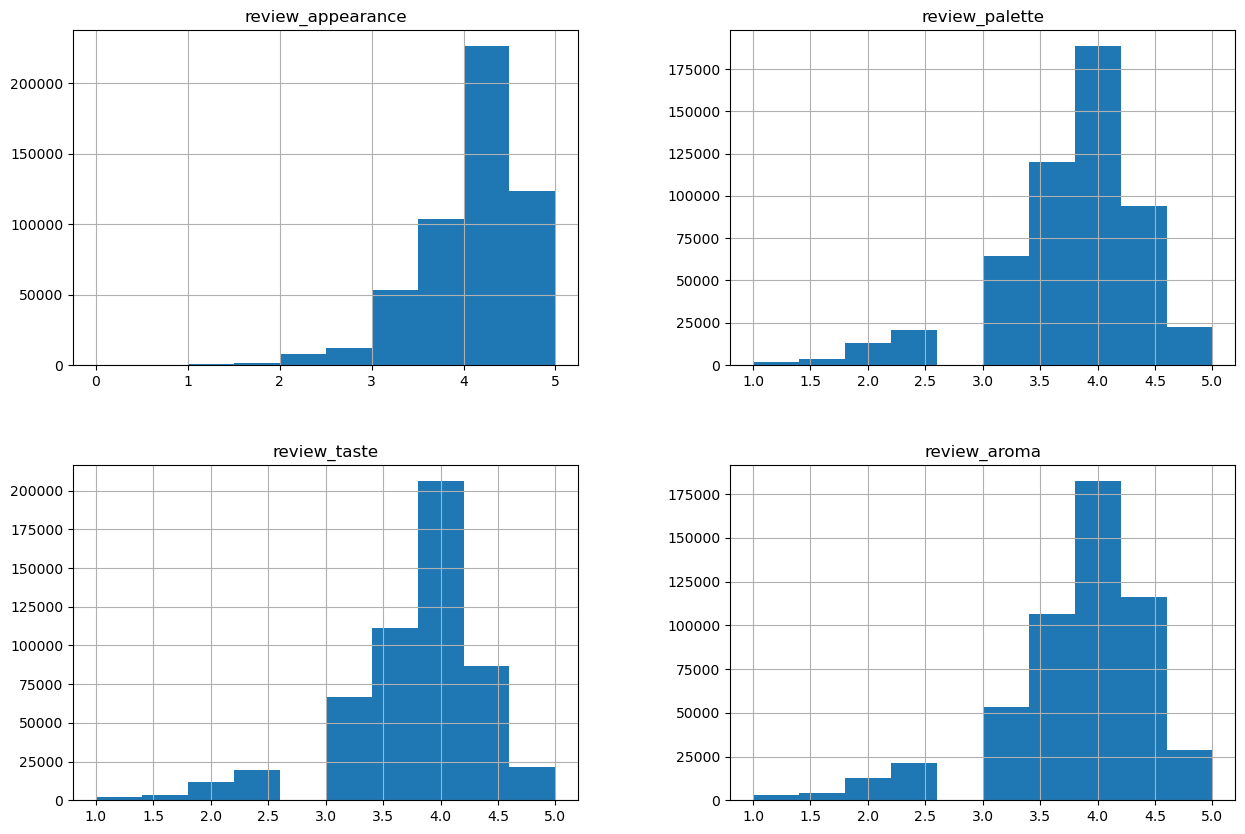

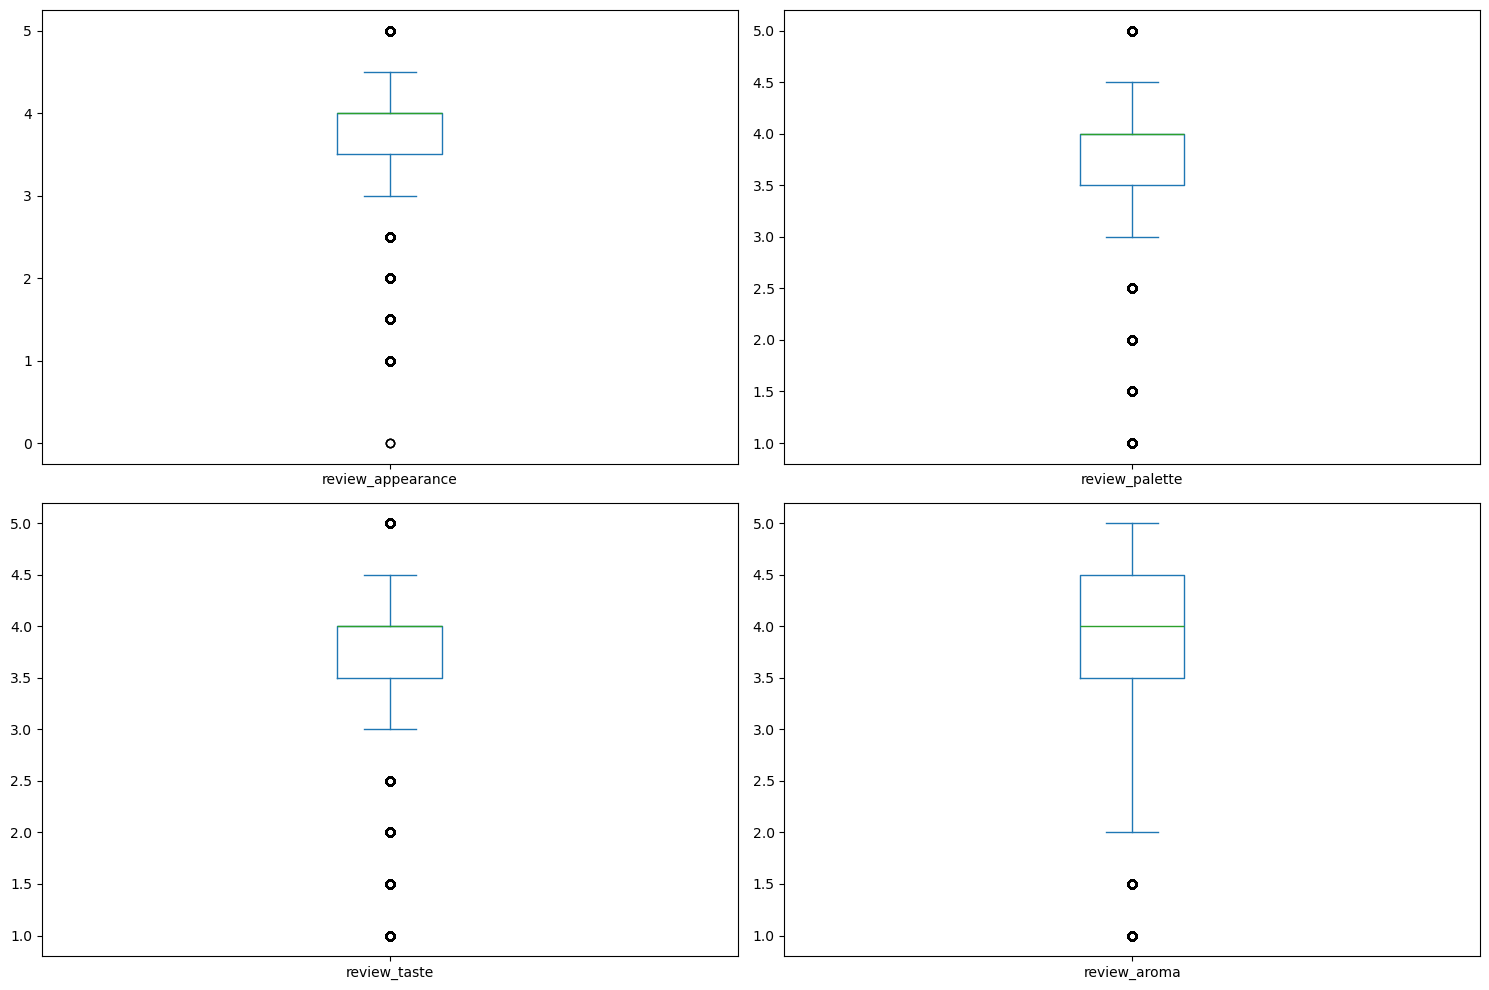

review_appearance    45331
review_palette       61761
review_taste         58051
review_aroma          7285
dtype: int64

In [5]:
# Histograms for review_appearance, review_palette, review_taste, review_aroma
df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']].hist(bins=10, figsize=(15, 10))
plt.show()

# Box Plots for review_appearance, review_palette, review_taste, review_aroma
df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']].plot(kind='box', subplots=True, layout=(2, 2), figsize=(15, 10))
plt.tight_layout()
plt.show()

# Outlier Detection using IQR for review_appearance, review_palette, review_taste, review_aroma
Q1 = df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']].quantile(0.25)
Q3 = df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']] < (Q1 - 1.5 * IQR)) | 
            (df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']] > (Q3 + 1.5 * IQR))).sum()

outliers

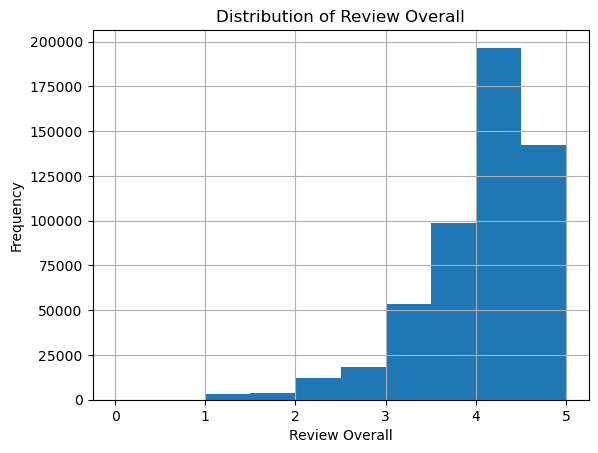

In [6]:
df['review_overall'].hist(bins=10)
plt.title('Distribution of Review Overall')
plt.xlabel('Review Overall')
plt.ylabel('Frequency')
plt.show()

### Correlation of beer features

In [7]:
corr_matrix = df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall']].corr()


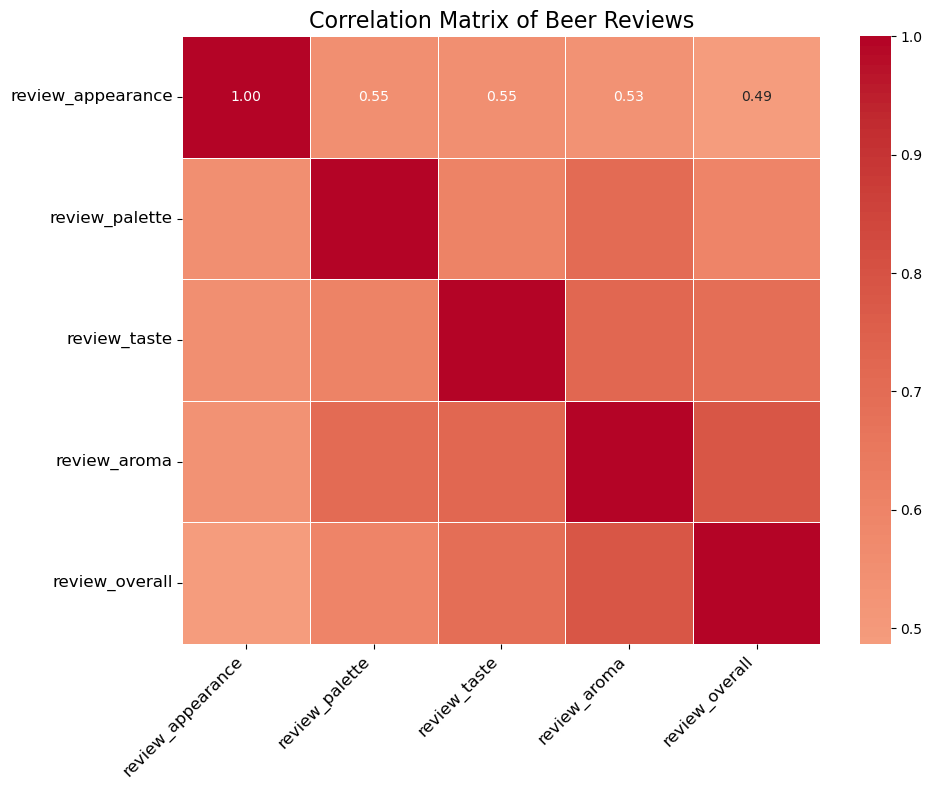

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

# Customize the title and axis labels
plt.title('Correlation Matrix of Beer Reviews', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

#### Appearance and Overall Rating (0.49): There is a moderate positive correlation between the beer's appearance and its overall rating. This suggests that while appearance influences the overall perception, it is not the dominant factor in determining the beer's quality from the consumer's perspective.

#### Palate, Taste, and Aroma: The features' palate, taste, and aroma' all show moderate correlations with each other, ranging from 0.53 to 0.55. This indicates that these sensory experiences often shape a customer's overall impression of a beer and are interconnected. For example, a beer with a pleasing aroma might also be expected to have a favorable taste and palate.

#### Overall Rating and Sensory Features: The overall rating shows the strongest correlation with the taste (0.55) and aroma (0.53) features. This highlights that these aspects are more influential in determining the overall satisfaction of customers, as compared to appearance or palate.
Aroma shall be a main focus of the nlp procedures to predict what beers should be presented within store

### Show how much beer features are effected by the others

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['review_appearance', 'review_palette', 'review_taste', 'review_aroma']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

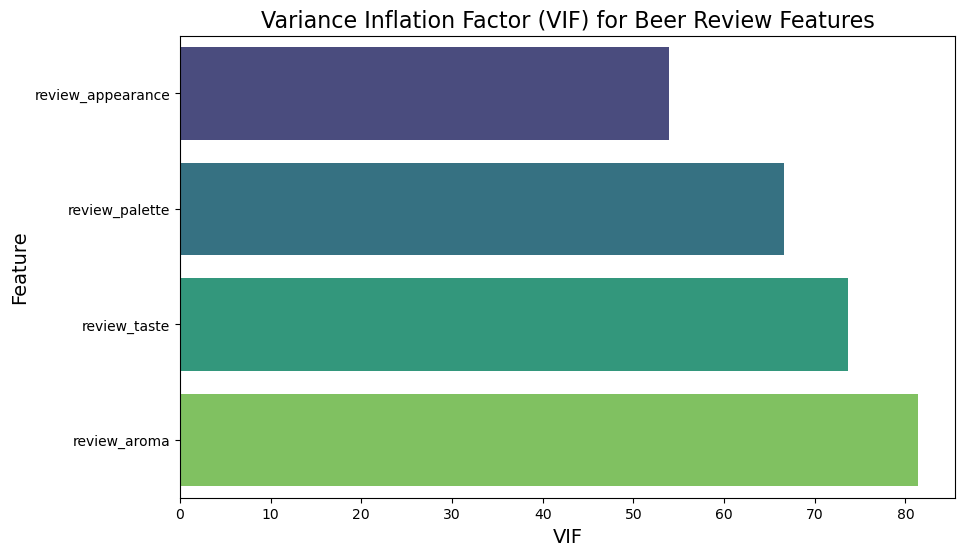

In [10]:
# Plotting the VIF data
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='feature', data=vif_data, palette='viridis')
plt.title('Variance Inflation Factor (VIF) for Beer Review Features', fontsize=16)
plt.xlabel('VIF', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

#### The appearance feature has the lowest VIF among the others, although it is still noticeably high, suggesting some multicollinearity, albeit less pronounced than the other features.
#### There is a notable degree of multicollinearity observed in the review palate, indicating a substantial correlation with other features.
#### Review Taste: Has a higher VIF, indicating stronger multicollinearity, which could be due to its close relationship with other sensory features such as aroma and palate.
#### Aroma Review: Stands out with the highest VIF value, signifying considerable multicollinearity. The findings indicate a significant association between the aroma  and the other features in the model.

In [11]:
# Basic Text Statistics
df['word_count'] = df['processed_review_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['processed_review_text'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['processed_review_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))

In [12]:
df['word_count']

0          23
1          36
2          41
3          44
4         108
         ... 
528865     62
528866     27
528867     77
528868     54
528869     40
Name: word_count, Length: 528870, dtype: int64

In [13]:
df['char_count']

0         147
1         231
2         267
3         265
4         753
         ... 
528865    416
528866    176
528867    459
528868    322
528869    285
Name: char_count, Length: 528870, dtype: int64

In [14]:
df['avg_word_length']

0         5.434783
1         5.444444
2         5.536585
3         5.045455
4         5.981481
            ...   
528865    5.725806
528866    5.555556
528867    4.974026
528868    4.981481
528869    6.150000
Name: avg_word_length, Length: 528870, dtype: float64

C:\Users\tsher\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tsher\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tsher\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


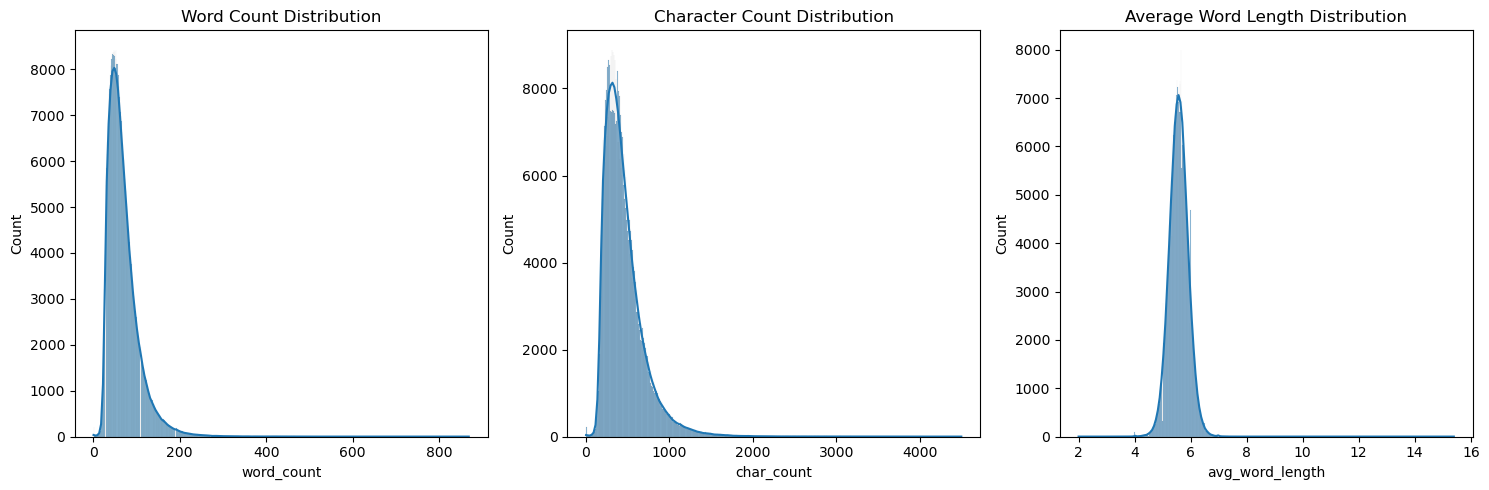

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['word_count'], ax=axes[0], kde=True)
axes[0].set_title('Word Count Distribution')

sns.histplot(df['char_count'], ax=axes[1], kde=True)
axes[1].set_title('Character Count Distribution')

sns.histplot(df['avg_word_length'], ax=axes[2], kde=True)
axes[2].set_title('Average Word Length Distribution')

plt.tight_layout()
plt.show()

#### The majority of reviews tend to be shorter, with a sharp decline in length as the word count increases. This suggests that most customers prefer to leave concise reviews, focusing on key points rather than providing lengthy feedback.
#### By comprehending these textual traits, we can optimize our sentiment analysis models for the review data. This is relevant for tailoring promotional strategies and customer engagement initiatives. By acknowledging the brevity and straightforwardness of customer feedback, we can ensure that our communications are aligned with how customers prefer to express their opinions.

In [16]:
df.head()

,Unnamed: 0,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,cleaned_review_text,processed_review_text,word_count,char_count,avg_word_length
0,0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823,a lot of foam but a lot in the smell some bana...,lot foam lot smell banana lactic tart good sta...,23,147,5.434783
1,1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097,dark red color light beige foam average in the...,dark red color light beige foam average smell ...,36,231,5.444444
2,2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,almost totally black beige foam quite compact ...,almost totally black beige foam quite compact ...,41,267,5.536585
3,3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,golden yellow color white compact foam quite c...,golden yellow color white compact foam quite c...,44,265,5.045455
4,4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206,according to the website the style for the cal...,according website style caldera cauldron chang...,108,753,5.981481


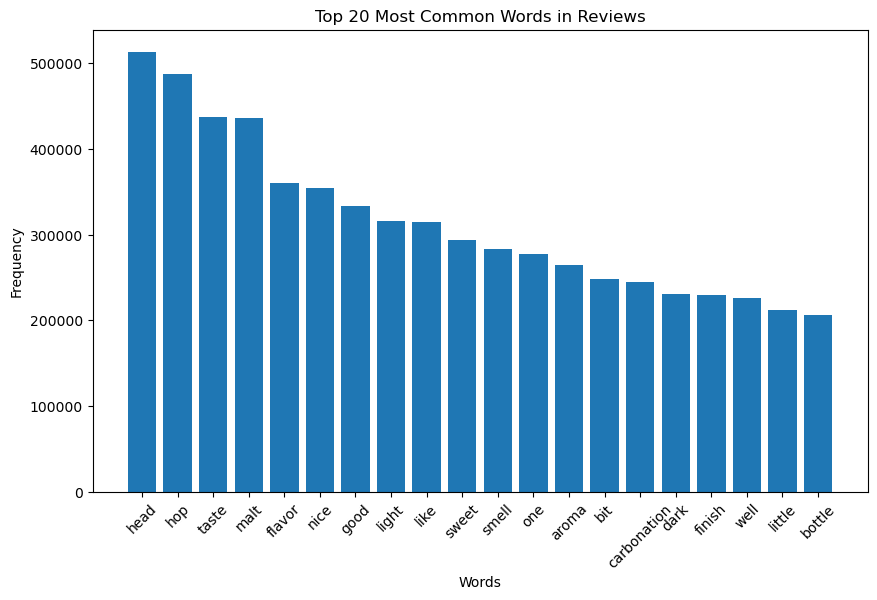

In [17]:
from collections import Counter

# Flatten all reviews into a single list of words
all_words = ' '.join(df['processed_review_text']).split()

# Get the most common words
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Plot word frequencies
words, frequencies = zip(*common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

#### Notably, the word "head" most frequent, talking about the foam build up of the beer, followed by terms "hop," "taste," "malt," and "flavor." These terms are directly related to the key characteristics that influence a consumer's perception of beer, such as taste, aroma, and overall experience.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Reduce the number of features
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['processed_review_text'])

# Get feature names
bigrams = vectorizer.get_feature_names_out()

# Calculate bigram counts directly from the sparse matrix
bigram_counts = np.asarray(X.sum(axis=0)).flatten()

# Create a DataFrame for bigrams
bigram_df = pd.DataFrame({'bigram': bigrams, 'count': bigram_counts}).sort_values(by='count', ascending=False).head(20)

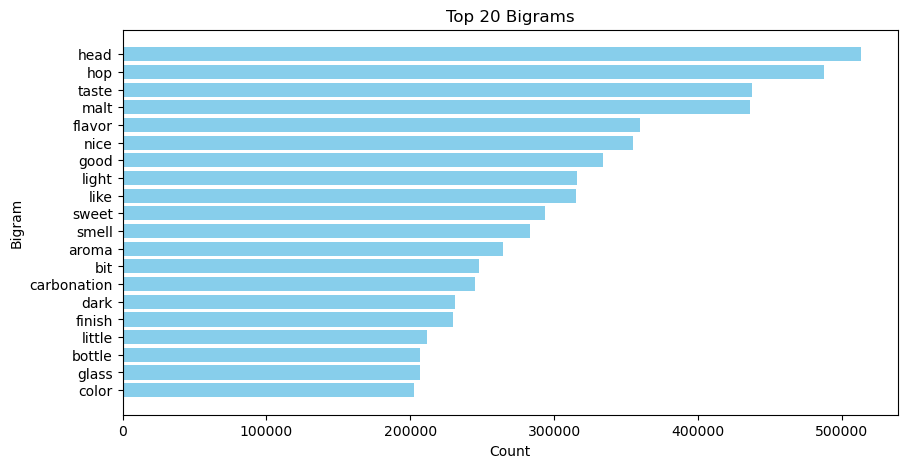

In [19]:
# Ensure bigram_df is sorted and limited to the top 20 bigrams
bigram_df = bigram_df.sort_values(by='count', ascending=False).head(20)

# Plot the top 20 bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigram_df['bigram'], bigram_df['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Top 20 Bigrams')
plt.gca().invert_yaxis()
plt.show()

### Dominant Themes:
####  bar chart to display the top 20 bigrams, we identify common themes and topics in the reviews. This analysis is essential to understand the language patterns and recurring terms that could influence or reflect the reviewers' ratings.
#### The frequency of words like "taste," "flavor," "aroma," and "bitterness" underlines the significance of sensory experiences in shaping customer satisfaction.words such as "sweet," "smell," "dark," and "light" highlight the sensual characteristics that customers often discuss. This can be useful for understanding what specific traits customers focus on when providing positive or negative feedback.
#### Reviewers frequently indicate the presence of technical aspects of beer-making using terms like "hop," "malt," and "carbonation."




### Top beer types reviewed

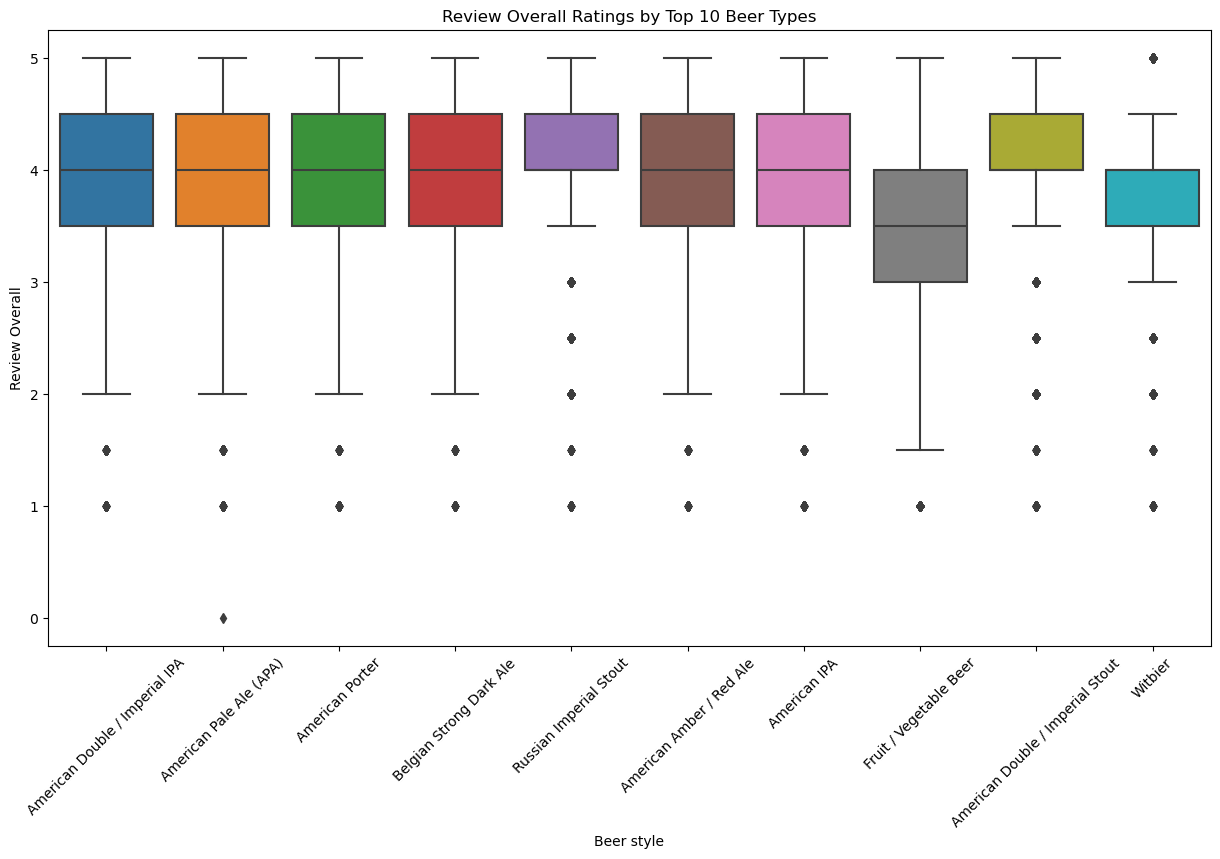

In [20]:
# Get top 10 most common beer types
top_beer_types = df['beer_style'].value_counts().head(10).index

# Filter DataFrame for these top beer types
top_beer_df = df[df['beer_style'].isin(top_beer_types)]

plt.figure(figsize=(15, 8))
sns.boxplot(x='beer_style', y='review_overall', data=top_beer_df)
plt.title('Review Overall Ratings by Top 10 Beer Types')
plt.xlabel('Beer style')
plt.ylabel('Review Overall')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Filtering the DataFrame for entries where 'review_overall' is 5.0
five_star_reviews = df[df['review_overall'] == 5.0]

# Counting the number of occurrences of 5.0 ratings for each beer
five_star_counts = five_star_reviews['beer_name'].value_counts().reset_index()

# Renaming columns for clarity
five_star_counts.columns = ['beer_name', 'count_of_five_stars']

# Sorting to find the beers with the most 5.0 ratings
top_five_star_beers = five_star_counts.sort_values(by='count_of_five_stars', ascending=False).head(10)

top_five_star_beers


,beer_name,count_of_five_stars
0,Founders KBS (Kentucky Breakfast Stout),520
1,Founders Breakfast Stout,507
2,La Fin Du Monde,492
3,Trappistes Rochefort 10,464
4,Tröegs Nugget Nectar,462
5,Sierra Nevada Pale Ale,416
6,Sierra Nevada Celebration Ale,335
7,Samuel Smith's Oatmeal Stout,318
8,Chimay Grande Réserve (Blue),307
9,Great Lakes Edmund Fitzgerald Porter,285


In [22]:
df.columns

Index(['Unnamed: 0', 'beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name',
       'beer_style', 'review_appearance', 'review_palette', 'review_overall',
       'review_taste', 'review_profileName', 'review_aroma', 'review_text',
       'review_time', 'cleaned_review_text', 'processed_review_text',
       'word_count', 'char_count', 'avg_word_length'],
      dtype='object')

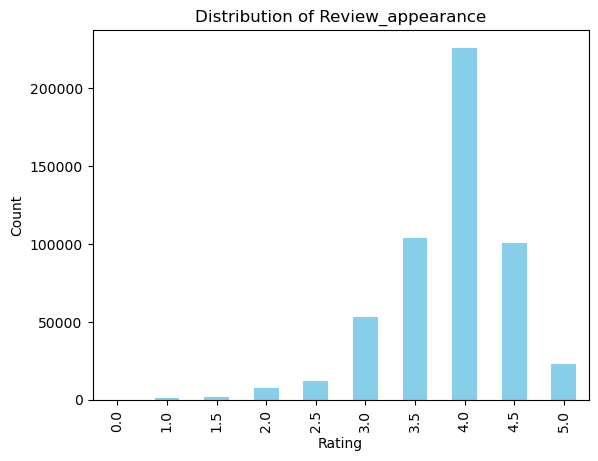

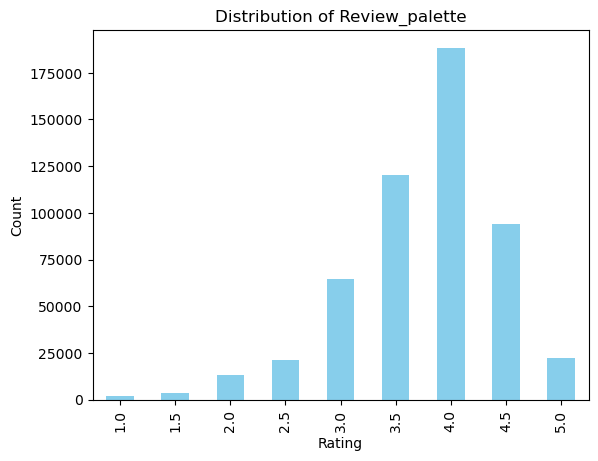

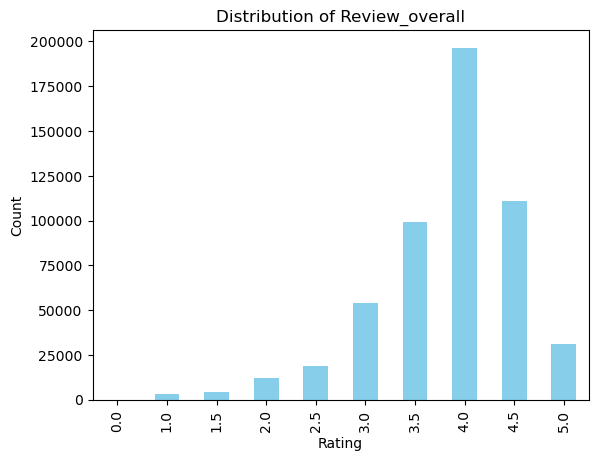

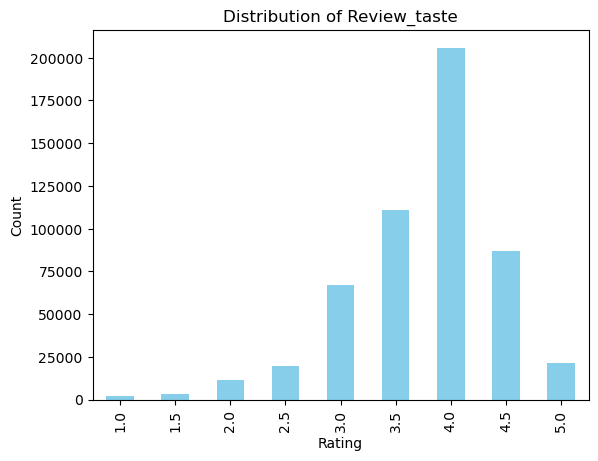

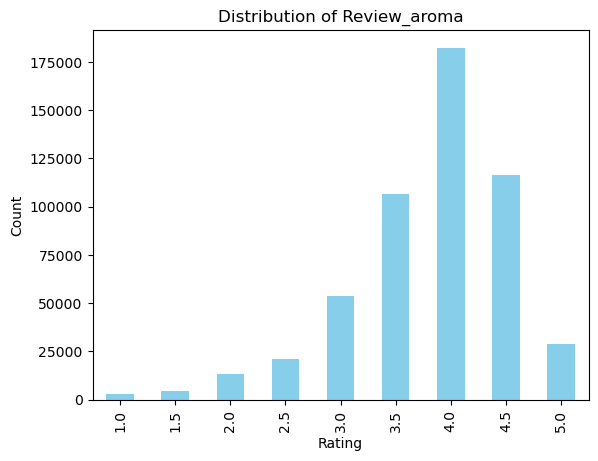

In [29]:
review_columns = ['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma']

for column in review_columns:
    df[column].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

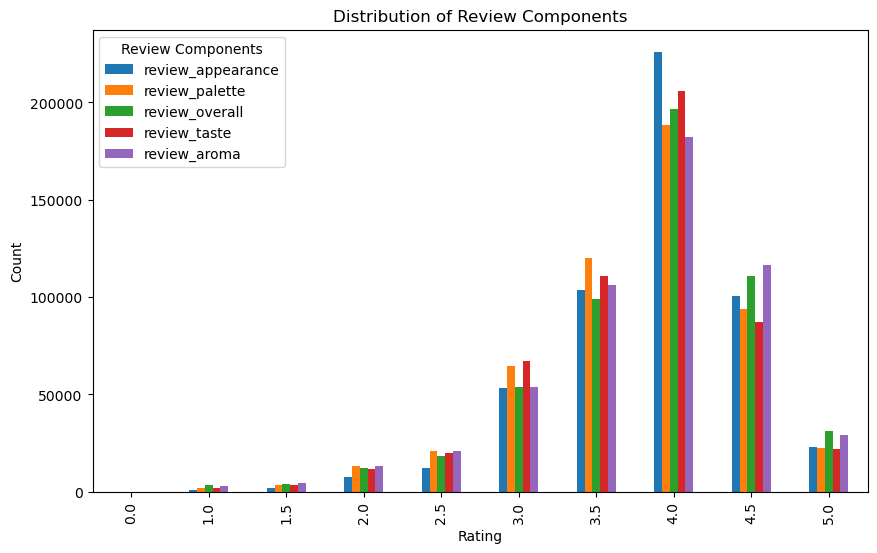

In [30]:
review_columns = ['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma']

# Create a DataFrame with value counts for each review component
review_distribution = pd.DataFrame({col: df[col].value_counts().sort_index() for col in review_columns})

# Plot the distribution
review_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Review Components')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Review Components')
plt.show()

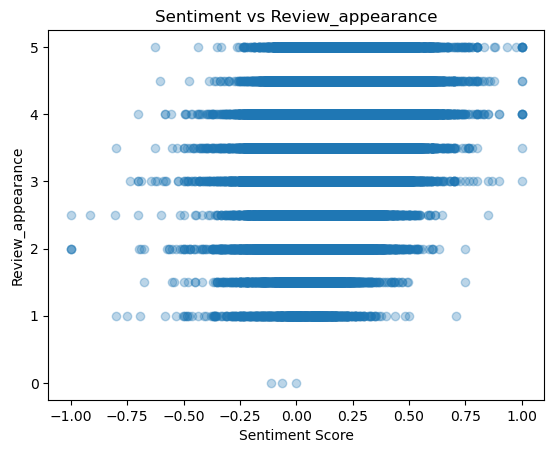

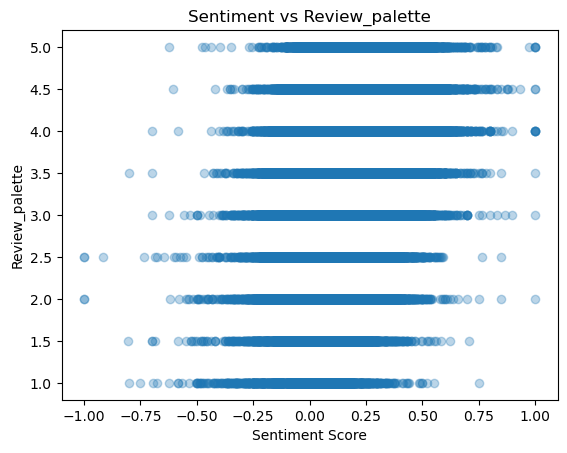

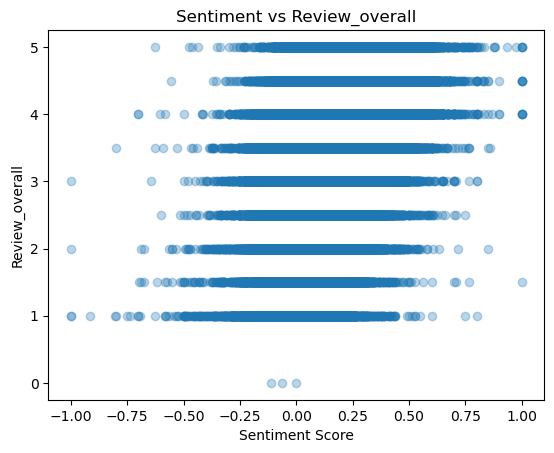

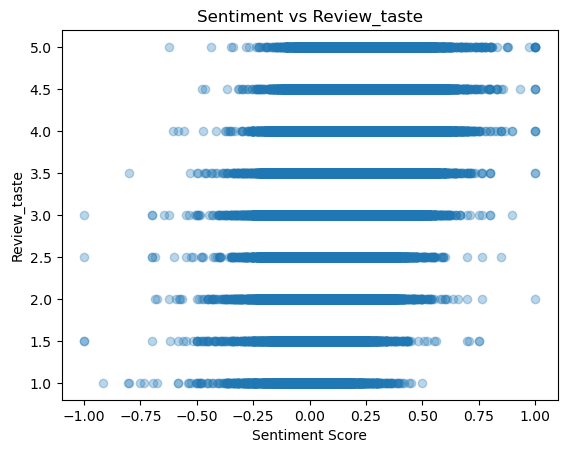

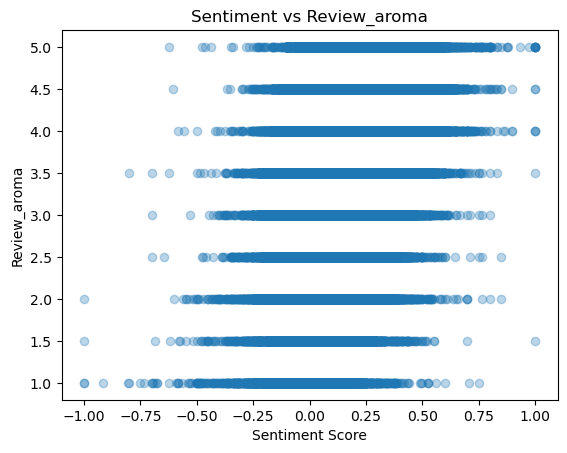

In [34]:
from textblob import TextBlob
import matplotlib.pyplot as plt

# Calculate sentiment polarity
df['sentiment'] = df['processed_review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# List of review points
review_columns = ['review_appearance', 'review_palette', 'review_overall', 'review_taste', 'review_aroma']

# Plot sentiment vs each review point
for column in review_columns:
    plt.scatter(df['sentiment'], df[column], alpha=0.3)
    plt.title(f'Sentiment vs {column.capitalize()}')
    plt.xlabel('Sentiment Score')
    plt.ylabel(column.capitalize())
    plt.show()